In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import matplotlib.pyplot as plt
import mpmath as mpm
import rebound
from mpmath import matrix, mpf
from tqdm import tqdm

mpm.mp.dps = 75

from jorbit.accelerations.newtonian import newtonian_gravity
from jorbit.integrators.ias15 import ias15_evolve, initialize_ias15_integrator_state
from jorbit.integrators.iasnn_arbitrary_prec import precompute
from jorbit.integrators.iasnn_arbitrary_prec import step as step_mp
from jorbit.integrators.iasnn_dd_prec import (
    setup_iasnn_integrator,
    step,
)
from jorbit.utils.doubledouble import DoubleDouble, dd_norm
from jorbit.utils.states import SystemState

In [2]:
#######################
# The DoubleDouble bits
#######################

# number of substeps
internal_pts = jnp.arange(4, 9)

# precompute the Gauss-Radau spacings and all associated weights
precomputed = []
for pts in internal_pts:
    precomputed.append(setup_iasnn_integrator(n_internal_points=int(pts)))

# the different numbers of steps per orbit to test
steps_per_orbit = list(set([int(i) for i in jnp.logspace(0, 3, 20)]))
steps_per_orbit.sort()

# loop through all the different numbers of steps per orbit and substeps
errs = jnp.zeros((7, len(steps_per_orbit)))
for s in tqdm(steps_per_orbit):
    dt = mpf("2") * mpm.pi / mpf(str(s))
    dt = DoubleDouble.from_string(str(dt))

    for pts in internal_pts:
        x0 = DoubleDouble(jnp.array([[1.0, 0, 0]]))
        v0 = DoubleDouble(jnp.array([[0, 1.0, 0]]))
        b = DoubleDouble(jnp.zeros((pts, 1, 3), dtype=jnp.float64))
        for _i in range(int(s)):
            x0, v0, b = step(x0, v0, b, dt, precomputed[pts - 4])
        errs = errs.at[pts - 4, steps_per_orbit.index(s)].set(
            dd_norm(x0 - DoubleDouble(jnp.array([[1.0, 0, 0]]))).hi
        )


############################
# The default integrator bit
############################

# set up the initial state of a single particle
init_state = SystemState(
    tracer_positions=jnp.array([[1.0, 0, 0]]),
    tracer_velocities=jnp.array([[0, 1.0, 0]]),
    massive_positions=jnp.array([[0.0, 0, 0]]),
    massive_velocities=jnp.array([[0.0, 0, 0]]),
    log_gms=jnp.array([0.0]),
    time=0.0,
    acceleration_func_kwargs={},
)

acc_func = jax.tree_util.Partial(newtonian_gravity)
a0 = acc_func(init_state)
init_integrator_state = initialize_ias15_integrator_state(a0)

final_position, _, _, _ = ias15_evolve(
    initial_system_state=init_state,
    acceleration_func=acc_func,
    times=jnp.array([2 * jnp.pi]),
    initial_integrator_state=init_integrator_state,
)
default_error = jnp.linalg.norm(final_position[0,1] - jnp.array([1.0, 0, 0]))


sim = rebound.Simulation()
sim.add(m=1.0)
sim.add(m=0.0, x=1.0, vy=1.0)
sim.integrate(2 * jnp.pi)
rebound_err = jnp.linalg.norm(
    jnp.array([sim.particles[1].x, sim.particles[1].y, sim.particles[1].z])
    - jnp.array([1.0, 0, 0])
)

100%|██████████| 18/18 [01:23<00:00,  4.67s/it]


/var/folders/mj/qxz5chg95r53_2nlv9f86qhm0000gn/T/ipykernel_71052/2627150379.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=12)
/var/folders/mj/qxz5chg95r53_2nlv9f86qhm0000gn/T/ipykernel_71052/2627150379.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12)


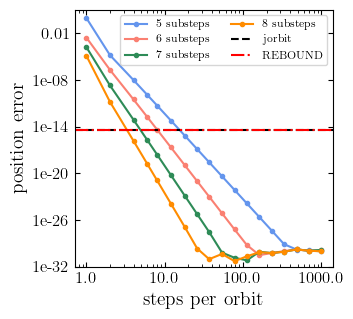

In [4]:
colors=["cornflowerblue", "salmon", "seagreen", "darkorange", "orchid"]
# fig, ax = plt.subplots(figsize=(4, 3))
fig, ax = plt.subplots(figsize=(10/3, 10/3))
for i, pts in enumerate(internal_pts[1:]):
    ax.plot(steps_per_orbit, errs[pts - 4], "o-", label=f"{pts} substeps", markersize=3, color=colors[i])
ax.axhline(default_error, color="k", linestyle="--", label="jorbit")
ax.axhline(rebound_err, color="r", linestyle="-.", label="REBOUND")
ax.set(xlabel="steps per orbit", ylabel="position error", xscale="log", yscale="log",
ylim=(1e-32, 1e1))
ax.set_xticklabels(ax.get_xticks(), fontsize=12)
ax.set_yticklabels(ax.get_yticks(), fontsize=12)
ax.legend(fontsize=8, ncols=2)
plt.savefig("figures/double_double_integrator.pdf", bbox_inches="tight")

In [4]:
default_error, rebound_err

(Array(3.5249581e-15, dtype=float64), Array(3.36025923e-15, dtype=float64))

In [5]:
# just for fun, to show how we can go even below 10^-32 by using the arbitrary precision
# mpmath implementation, here's one (slow) example:

steps_per_orbit = 100
n_internal_points = 7

pre = precompute(n_internal_points)
b_x_denoms, b_v_denoms, h, r, c, d = pre
x0 = matrix([["1.0", "0", "0"]])
v0 = matrix([["0", "1.0", "0"]])
a0 = matrix([["-1.0", "0", "0"]])
b = mpm.ones(n_internal_points, 3)

dt = mpf("2") * mpm.pi / mpf(str(steps_per_orbit))

for _i in tqdm(range(steps_per_orbit)):
    x0, v0, b = step_mp(x0, v0, b, dt, pre)

mpm.mnorm(x0 - matrix([["1.0", "0", "0"]]))

100%|██████████| 100/100 [00:07<00:00, 12.66it/s]


mpf('9.13598750383024194556124305126853116770389002898237015371525892080499150982014e-35')